# Preprocessing
## Imports

In [1]:
import networkx as nx
from langchain_core.documents import Document
import pandas as pd
import json
import re

## Functions

In [2]:
def get_base_id(id: str) -> str:
    match = re.match(r'\b(?:Article|Art\.|Rule|R\.)\s\d+[a-zA-Z]?\b', id)
    return match.group()

In [3]:
def load_data(path: str) -> list:
    with open(path, 'r') as js:
        data = json.load(js)
    return data

In [4]:
def create_doc(row: pd.Series) -> Document:
    doc = Document(page_content=row["text"], id=row["title"], metadata=row.drop(labels=["text", "title"]).to_dict())
    return doc

In [5]:
def add_to_graph(df: pd.DataFrame, g: nx.MultiGraph, label: str):
    for _, row in df.iterrows():
        doc = create_doc(row)
        if "implementation" in df.columns:
            id = doc.id
        else:
            id = get_base_id(doc.id)
        g.add_node(id, data=doc, label=label)

In [6]:
def connect(df: pd.DataFrame, g: nx.MultiGraph):
    if "implementation" in df.columns:
        for _, row in df.iterrows():
            if isinstance(row["implementation"], dict):
                node1_id = row["title"]
                implementations = row["implementation"]
                for implementation in implementations.keys():
                    if get_base_id(implementation) in g:
                        g.add_edge(node1_id, get_base_id(implementation), key="implements")
    else:
        for _, row in df.iterrows():
            node1_id = get_base_id(row["title"])
            references = row["references"]
            for ref in references:
                if get_base_id(ref) in g:
                    g.add_edge(node1_id, get_base_id(ref), key="references")

In [7]:
def clean_list(lst):
    if isinstance(lst, list):
        return [s.replace('\xa0', ' ').strip() if isinstance(s, str) else s for s in lst]
    return lst

In [8]:
def clean_dict(dct):
    VALID_KEY_PATTERN = re.compile(r'^(?:Article|Art\.|Rule|R\.)\s\d+[a-zA-Z]?$')
    if isinstance(dct, dict):
        cleaned = {}
        for k, v in dct.items():
            clean_key = k.replace('\xa0', ' ').strip()
            if VALID_KEY_PATTERN.match(clean_key):
                clean_value = [w.replace('\xa0', ' ').strip() for w in v]
                cleaned[clean_key] = clean_value
        return cleaned
    return dct

In [9]:
def get_text(dct):
    if isinstance(dct, dict):
        flat = []
        for v in dct.values():
            if isinstance(v, list):
                flat.extend(str(item) for item in v)
            else:
                flat.append(str(v))
        return " ".join(flat)
    return dct

## Main

### EPC

In [10]:
path = "../../resources/extracted_data/EPC_data.json"
articles = load_data(path)
articles_df = pd.DataFrame(articles)
articles_df = articles_df.replace(u"\xa0", ' ', regex=True)
articles_df = articles_df.map(lambda x: x.strip() if isinstance(x, str) else x)
articles_df['references'] = articles_df['references'].apply(clean_list)
articles_df

book                                           part  \
0    EPC  Part I - General and institutional provisions   
1    EPC  Part I - General and institutional provisions   
2    EPC  Part I - General and institutional provisions   
3    EPC  Part I - General and institutional provisions   
4    EPC  Part I - General and institutional provisions   
..   ...                                            ...   
163  EPC                    Part XII - Final provisions   
164  EPC                    Part XII - Final provisions   
165  EPC                    Part XII - Final provisions   
166  EPC                    Part XII - Final provisions   
167  EPC                    Part XII - Final provisions   

                            chapter  \
0    Chapter I - General provisions   
1    Chapter I - General provisions   
2    Chapter I - General provisions   
3    Chapter I - General provisions   
4    Chapter I - General provisions   
..                              ...   
163           Art. 167  - (deleted)   
164           Art. 167  - (deleted)   
165           Art. 167  - (deleted)   
166           Art. 167  - (deleted)   
167           Art. 167  - (deleted)   

                                                 title  \
0    Article 1 - European law for the grant of patents   
1                          Article 2 - European patent   
2                       Article 3 - Territorial effect   
3             Article 4 - European Patent Organisation   
4    Article 4a - Conference of ministers of the Co...   
..                                                 ...   
163                         Article 174 - Denunciation   
164      Article 175 - Preservation of acquired rights   
165  Article 176 - Financial rights and obligations...   
166          Article 177 - Languages of the Convention   
167       Article 178 - Transmission and notifications   

                                                  text  \
0    A system of law, common to the Contracting Sta...   
1    (1) Patents granted under this Convention shal...   
2    The grant of a European patent may be requeste...   
3    (1) A European Patent Organisation, hereinafte...   
4    A conference of ministers of the Contracting S...   
..                                                 ...   
163  Any Contracting State may at any time denounce...   
164  (1) In the event of a State ceasing to be part...   
165  (1) Any State which has ceased to be a party t...   
166  (1) This Convention, drawn up in a single orig...   
167  (1) The Government of the Federal Republic of ...   

                                            references  \
0                                                        
1    [Article 63 Term of the European patent, Artic...   
2    [Article 79 Designation of Contracting States,...   
3    [Article 4a Conference of ministers of the Con...   
4             [Article 4 European Patent Organisation]   
..                                                 ...   
163  [Article 175 Preservation of acquired rights, ...   
164                                                      
165                                                      
166                                                      
167  [Article 165 Signature – Ratification, Article...   

                                                 url  
0      https://www.epo.org/en/legal/epc/2020/a1.html  
1      https://www.epo.org/en/legal/epc/2020/a2.html  
2      https://www.epo.org/en/legal/epc/2020/a3.html  
3      https://www.epo.org/en/legal/epc/2020/a4.html  
4     https://www.epo.org/en/legal/epc/2020/a4a.html  
..                                               ...  
163  https://www.epo.org/en/legal/epc/2020/a174.html  
164  https://www.epo.org/en/legal/epc/2020/a175.html  
165  https://www.epo.org/en/legal/epc/2020/a176.html  
166  https://www.epo.org/en/legal/epc/2020/a177.html  
167  https://www.epo.org/en/legal/epc/2020/a178.html  

[168 rows x 7 columns]

### EPC regulations


In [11]:
path = "../../resources/extracted_data/EPC_regulations.json"
rules = load_data(path)
rules_df = pd.DataFrame(rules)
rules_df = rules_df.replace(u"\xa0", ' ', regex=True)
rules_df = rules_df.map(lambda x: x.strip() if isinstance(x, str) else x)
rules_df['references'] = rules_df['references'].apply(clean_list)
rules_df

book                                               part  \
0    EPC  Part I - Implementing Regulations to part I of...   
1    EPC  Part I - Implementing Regulations to part I of...   
2    EPC  Part I - Implementing Regulations to part I of...   
3    EPC  Part I - Implementing Regulations to part I of...   
4    EPC  Part I - Implementing Regulations to part I of...   
..   ...                                                ...   
171  EPC  Part IX - Implementing Regulations to Part X o...   
172  EPC  Part IX - Implementing Regulations to Part X o...   
173  EPC  Part IX - Implementing Regulations to Part X o...   
174  EPC  Part IX - Implementing Regulations to Part X o...   
175  EPC  Part IX - Implementing Regulations to Part X o...   

                            chapter section  \
0    Chapter I - General provisions           
1    Chapter I - General provisions           
2    Chapter I - General provisions           
3    Chapter I - General provisions           
4    Chapter I - General provisions           
..                              ...     ...   
171                                           
172                                           
173                                           
174                                           
175                                           

                                                 title  \
0                         Rule 1 - Written proceedings   
1    Rule 2 - Filing of and formal requirements for...   
2             Rule 3 - Language in written proceedings   
3                Rule 4 - Language in oral proceedings   
4               Rule 5 - Certification of translations   
..                                                 ...   
171            Rule 161 - Amendment of the application   
172                   Rule 162 - Claims incurring fees   
173  Rule 163 - Examination of certain formal requi...   
174  Rule 164 - Unity of invention and further sear...   
175  Rule 165 - The Euro-PCT application as conflic...   

                                                  text  \
0    In written proceedings before the European Pat...   
1    (1)3 In proceedings before the European Patent...   
2    (1) In written proceedings before the European...   
3    (1) Any party to oral proceedings before the E...   
4    Where the translation of a document is require...   
..                                                 ...   
171  (1) If the European Patent Office has acted as...   
172  (1) If the application documents on which the ...   
173  (1) Where the designation of the inventor unde...   
174  (1) If the European Patent Office considers th...   
175  A Euro-PCT application shall be considered as ...   

                                            references  \
0    [Rule 3 Language in written proceedings, Rule ...   
1    [Rule 3 Language in written proceedings, Rule ...   
2    [Article 14 Languages of the European Patent O...   
3    [Article 14 Languages of the European Patent O...   
4    [Article 14 Languages of the European Patent O...   
..                                                 ...   
171  [Article 123 Amendments, Article 152 The Europ...   
172  [Article 153 The European Patent Office as des...   
173  [Article 81 Designation of the inventor, Artic...   
174  [Article 82 Unity of invention, Article 153 Th...   
175                                                      

                                                 url  
0      https://www.epo.org/en/legal/epc/2020/r1.html  
1      https://www.epo.org/en/legal/epc/2020/r2.html  
2      https://www.epo.org/en/legal/epc/2020/r3.html  
3      https://www.epo.org/en/legal/epc/2020/r4.html  
4      https://www.epo.org/en/legal/epc/2020/r5.html  
..                                               ...  
171  https://www.epo.org/en/legal/epc/2020/r161.html  
172  https://www.epo.org/en/legal/epc/2020/r162.html  
173  https://www.epo.org/en/legal/epc/2020/r163.html  
174  https://www.epo.org/en/legal/epc/202

### EPO guidelines

In [12]:
path = "../../resources/extracted_data/EPO_guidelines.json"
guidelines = load_data(path)
guidelines_df = pd.DataFrame(guidelines)
guidelines_df = guidelines_df.replace(u"\xa0", ' ', regex=True)
guidelines_df = guidelines_df.map(lambda x: x.strip() if isinstance(x, str) else x)
guidelines_df['implementation'] = guidelines_df['implementation'].apply(clean_dict)
guidelines_df["text"] = guidelines_df["implementation"].apply(get_text)
guidelines_df

book                                             part  \
0     EPO_guidelines  Part A – Guidelines for Formalities Examination   
1     EPO_guidelines  Part A – Guidelines for Formalities Examination   
2     EPO_guidelines  Part A – Guidelines for Formalities Examination   
3     EPO_guidelines  Part A – Guidelines for Formalities Examination   
4     EPO_guidelines  Part A – Guidelines for Formalities Examination   
...              ...                                              ...   
1779  EPO_guidelines              Part H – Amendments and Corrections   
1780  EPO_guidelines              Part H – Amendments and Corrections   
1781  EPO_guidelines              Part H – Amendments and Corrections   
1782  EPO_guidelines              Part H – Amendments and Corrections   
1783  EPO_guidelines              Part H – Amendments and Corrections   

                                chapter  \
0              Chapter I – Introduction   
1              Chapter I – Introduction   
2              Chapter I – Introduction   
3              Chapter I – Introduction   
4              Chapter I – Introduction   
...                                 ...   
1779  Chapter VI – Correction of errors   
1780  Chapter VI – Correction of errors   
1781  Chapter VI – Correction of errors   
1782  Chapter VI – Correction of errors   
1783  Chapter VI – Correction of errors   

                                                  title  \
0                              Chapter I – Introduction   
1                                           1. Overview   
2         2. Responsibility for formalities examination   
3                                  3. Purpose of Part A   
4                4. Other parts relating to formalities   
...                                                 ...   
1779  3.2 Allowability of the correction of bibliogr...   
1780  3.3 Correction of the decision to grant while ...   
1781         4. Correction of formatting/editing errors   
1782    5. Correction of the translations of the claims   
1783                           6. Errors in publication   

                                         implementation  \
0                                                         
1     Part A of the Guidelines deals with:\n(i)the r...   
2     {'Rule 10': ['The matters covered in this part...   
3     This part of the Guidelines is intended to pro...   
4     Formalities officers should not concern themse...   
...                                                 ...   
1779  The sole reason for allowing the correction of...   
1780  Even during opposition proceedings, the examin...   
1781  Formatting/editing errors which were already c...   
1782  According to Art. 70(1), the text of a patent ...   
1783  Errors in publication occur where the content ...   

                                                   text  
0                                                        
1     Part A of the Guidelines deals with:\n(i)the r...  
2     The matters covered in this part are intended ...  
3     This part of the Guidelines is intended to pro...  
4     Formalities officers should not concern themse...  
...                                                 ...  
1779  The sole reason for allowing the correction of...  
1780  Even during opposition proceedings, the examin...  
1781  Formatting/editing errors which were already c...  
1782  According to Art. 70(1), the text of a patent ...  
1783  Errors in publication occur where the content ...  

[1784 rows x 6 columns]

In [13]:
rules_df[rules_df["title"].str.contains("Rule 5 ")]["text"].item()

'Where the translation of a document is required, the European Patent Office may require that a certificate that the translation corresponds to the original text be filed within a period to be specified. If the certificate is not filed in due time, such document shall be deemed not to have been filed, unless otherwise provided.'

In [14]:
g = nx.MultiGraph()

In [15]:
add_to_graph(articles_df, g, "Article")
add_to_graph(rules_df, g, "Rule")
add_to_graph(guidelines_df, g, "Guideline")
connect(articles_df, g)
connect(rules_df, g)
connect(guidelines_df, g)

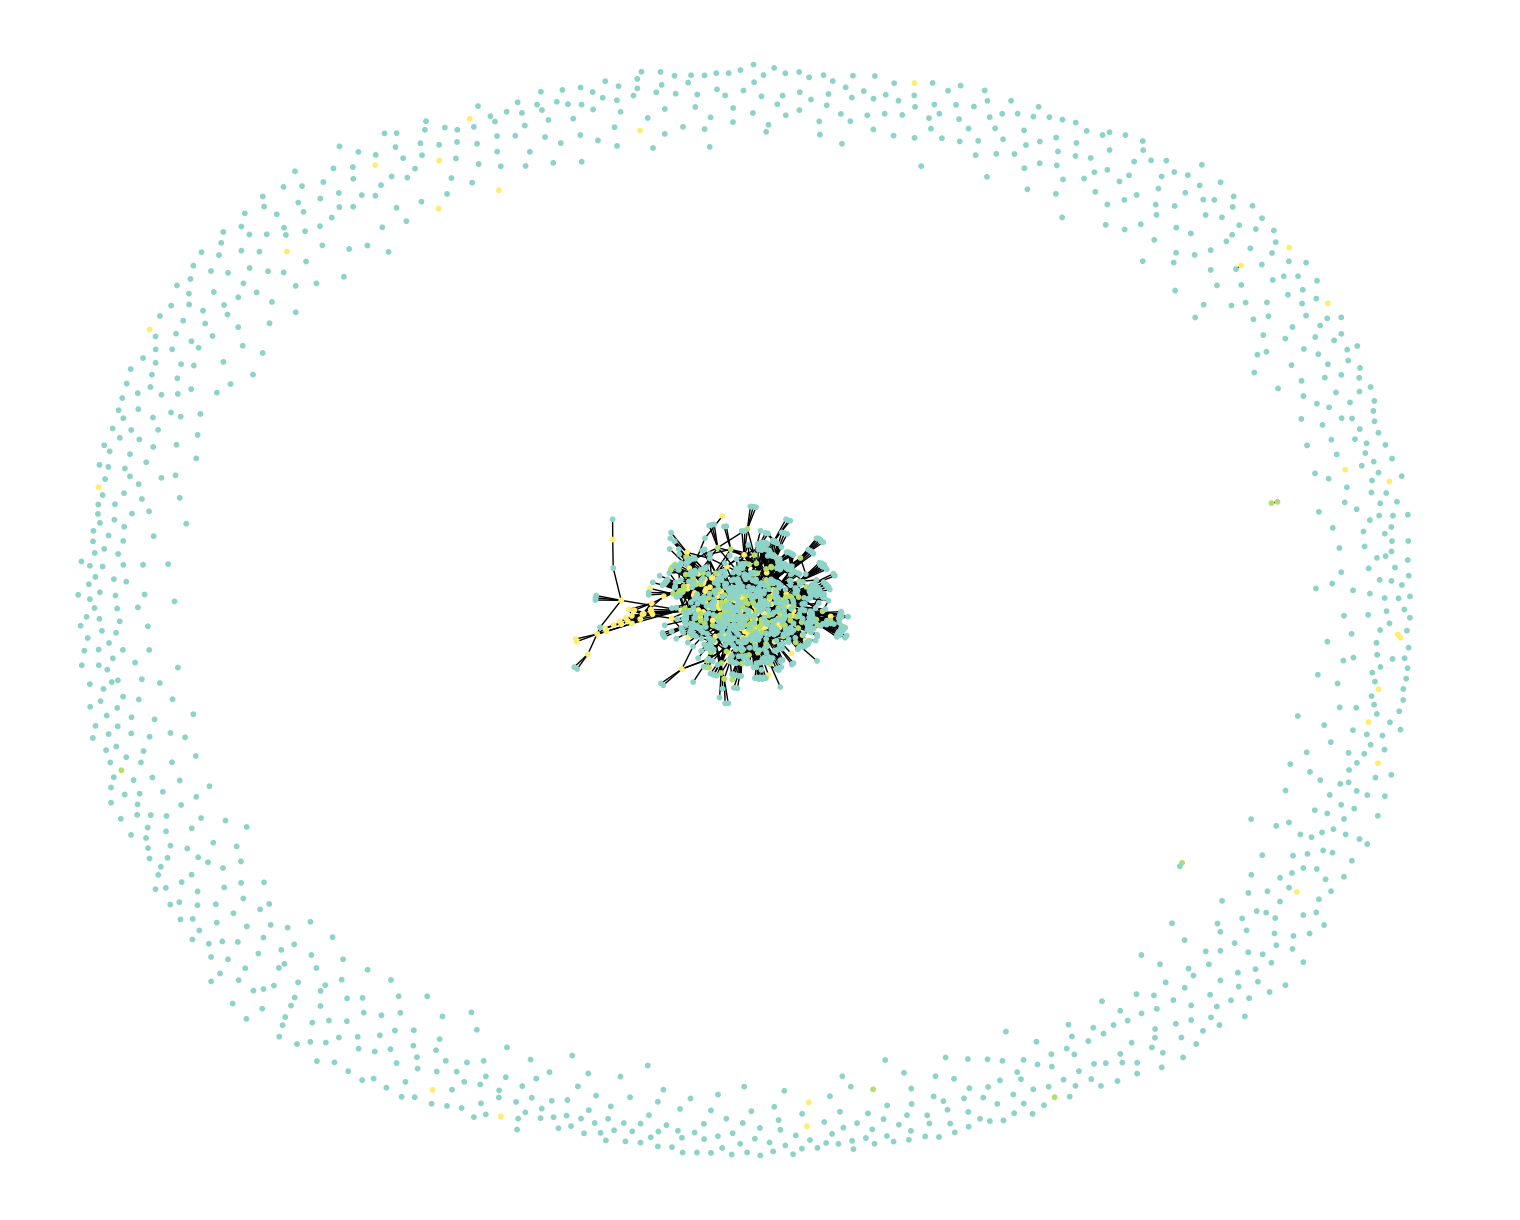

In [16]:
import matplotlib.pyplot as plt


# Get labels from node attributes
labels = nx.get_node_attributes(g, 'label')

# Map labels to unique colors
unique_labels = list(set(labels.values()))
label_color_map = {label: i for i, label in enumerate(unique_labels)}

# Assign a color to each node based on its label
node_colors = [label_color_map[labels[node]] for node in g.nodes()]

plt.figure(figsize=(15, 12))
# Draw graph without labels, but with colors
pos = nx.spring_layout(g)
nx.draw(g, pos, node_color=node_colors, with_labels=False, cmap=plt.cm.Set3, node_size=10)


plt.show()

In [17]:
for id, doc in g.nodes(data=True):
    print(id, doc)

Article 1 {'data': Document(id='Article 1 - European law for the grant of patents', metadata={'book': 'EPC', 'part': 'Part I - General and institutional provisions', 'chapter': 'Chapter I - General provisions', 'references': '', 'url': 'https://www.epo.org/en/legal/epc/2020/a1.html'}, page_content='A system of law, common to the Contracting States, 2 for the grant of patents for invention is established by this Convention.\n\n\n2There are currently 3839 Contracting States: AL, AT, BE, BG, CH, CY, CZ, DE, DK, EE, ES, FI, FR, GB, GR, HR, HU, IE, IS, IT, LI, LT, LU, LV, MC, ME, MK, MT, NL, NO, PL, PT, RO, RS, SE, SI, SK, SM, TR.'), 'label': 'Article'}
Article 2 {'data': Document(id='Article 2 - European patent', metadata={'book': 'EPC', 'part': 'Part I - General and institutional provisions', 'chapter': 'Chapter I - General provisions', 'references': ['Article 63 Term of the European patent', 'Article 65 Translation of the European patent', 'Article 68 Effect of revocation or limitation o

In [18]:
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_core.documents import Document


texts = []
metadatas = []
ids = []
for id, doc in g.nodes(data=True):
    if doc["data"].page_content:
        ids.append(id)
        metadatas.append({"label": doc["label"]})
        texts.append(doc["data"].page_content)

#local_embeddings = OllamaEmbeddings(model="all-minilm")
#vectorstore = Chroma.from_texts(texts, embedding=local_embeddings, ids=ids, metadatas=metadatas)

""" config_path = "../../config/retriever_config.yaml"
retriever = Retriever(config_path, articles_df) """

' config_path = "../../config/retriever_config.yaml"\nretriever = Retriever(config_path, articles_df) '

In [20]:
from src.system.rag import Retriever
articles = {}
articles["texts"] = texts
articles["ids"] = ids
articles["metadatas"] = metadatas
config_path = "../../config/retriever_config.yaml"
local_embeddings = OllamaEmbeddings(model="all-minilm")
retriever = Retriever(config_path, articles, local_embeddings)

/home/timothee/Documents/data_challenges/PatentAssist/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
query = "How is decided whether an idea is novel or not?"
retriever.retrieve_documents(query, rerank=True)

[Document(id='9.2.1 Particularly relevant documents', metadata={'label': 'Guideline'}, page_content='Where a document cited in the search report is particularly relevant, it is labelled with the letter "X" or "Y". Category "X" applies where a document shows on its own that a claimed invention cannot be considered novel or to involve an inventive step. Category "Y" applies where a document suggests that a claimed invention cannot be considered to involve an inventive step when the document is combined with one or more other documents of the same category and this combination is obvious to a person skilled in the art. However, if a document (called a "primary document") explicitly refers to another document as providing more detailed information on certain features (see G‑IV, 8) and the combination of these documents is considered particularly relevant, the primary document is labelled with the letter "X", i.e. not "Y", and the document it refers to (the "secondary document") is labelled

In [26]:
for src, dest in g.edges("Article 56"):
    if g.nodes[dest]["label"] == "Guideline":
        print(dest)

9.2.1 Particularly relevant documents
4.22 Broad claims
5.1 State of the art pursuant to Art. 54(3)
1. General


In [29]:
g.nodes["Article 1"]["data"].metadata["url"]

'https://www.epo.org/en/legal/epc/2020/a1.html'